# L1 Regularization 練習2

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [173]:
train = pd.read_csv("./house prices/train.csv")
test = pd.read_csv("./house prices/test.csv")

## 把train和test的X資料合併起來一起進行data preprocessing

In [174]:
X_train = train.loc[:, "MSSubClass":"SaleCondition"]
X_test = test.loc[:, "MSSubClass":"SaleCondition"]
all_data = pd.concat((X_train, X_test))

## 以下為懶人資料前處理
1. 抓numerical參數，只要是skew超過0.75的就全部取log
2. 把全部參數不分青紅皂白都取one-hot encoding(get_dummies)
3. 把全部的missing value都取median
4. feature scaling

That's all.

In [175]:
# 1. 抓numerical參數，只要是skew超過0.75的就全部取log

numerical_cols = all_data.select_dtypes(exclude=['object']).columns

from scipy.stats import skew

for col in numerical_cols:    
    if skew(all_data[col].dropna()) > 0.75:     
        #print 'skew > 0.75, col = %s' % (col)
        # 要小心，這裡的col型態是str，不能用all_data[col]，要用all_data.loc[:, col]
        all_data.loc[:, col] = np.log1p(all_data.loc[:, col])
        

# y也要一起處理
print 'y (SalePrice) skew = %f' % (skew(train.SalePrice))
y = np.log1p(train.SalePrice)

y (SalePrice) skew = 1.880941


In [176]:
# 2. 把全部參數不分青紅皂白都取one-hot encoding(get_dummies)
all_data = pd.get_dummies(all_data)

In [177]:
#3. 把全部的missing value都取median
all_data = all_data.fillna(all_data.median())

In [178]:
#4. feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(all_data[numerical_cols])
all_data[numerical_cols] = sc.transform(all_data[numerical_cols])

## 以上就是Data Preprocessing (跑完分數結果還不錯，但如果要更好，要細到對每個參數做處理)

## 把資料切 train, valid, test

In [179]:
# 先把all_data切回去train和test
n = train.shape[0]

# 從第1筆取到第n筆
X = all_data[:n]

# 從第n筆取到最後1筆
X_test = all_data[n:]

In [180]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

## 跑跑Lasso Model，做一下cross validation

In [181]:
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5))
    #print 'alpha = %f, rmse = %f' % (model.alpha, rmse.mean()) 
    return rmse.mean()
    
rmse_train = []
rmse_valid = []
alphas = []
for c in np.arange(-6, 1):    
    rmse_train.append(rmse_cv(Lasso(alpha=10**c), X_train, y_train))    
    rmse_valid.append(rmse_cv(Lasso(alpha=10**c), X_valid, y_valid))
    alphas.append(10**c)

print 'Lasso rmse_train min = %f' % (np.min(rmse_train))

Lasso rmse_train min = 0.116520


## Lasso, C=0.001結果最好

best alpha
rmse_train    0.001
rmse_valid    0.001
dtype: float64


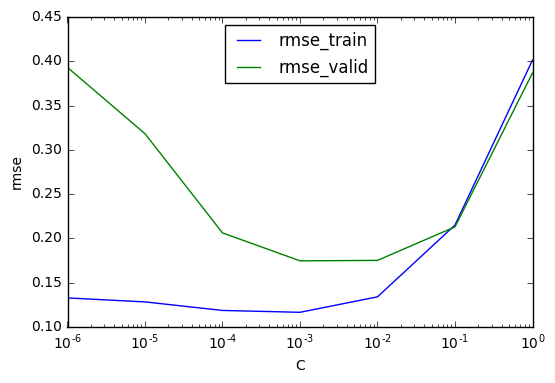

In [182]:
rmse = pd.DataFrame({'rmse_train':rmse_train, 'rmse_valid':rmse_valid}, index=alphas)
print 'best alpha'
print rmse.idxmin()

rmse.plot()
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('rmse')
plt.show()

## 跑跑Ridge Model (還是Lasso的結果比較好)

In [183]:
rmse_train = []
rmse_valid = []
alphas = []

for c in np.arange(-6, 6):
    rmse_train.append(rmse_cv(Ridge(alpha=10**c), X_train, y_train))    
    rmse_valid.append(rmse_cv(Ridge(alpha=10**c), X_valid, y_valid))
    alphas.append(10**c)
    
print 'Ridge rmse_train min = %f' % (np.min(rmse_train))

Ridge rmse_train min = 0.117255


best alpha
rmse_train     10.0
rmse_valid    100.0
dtype: float64


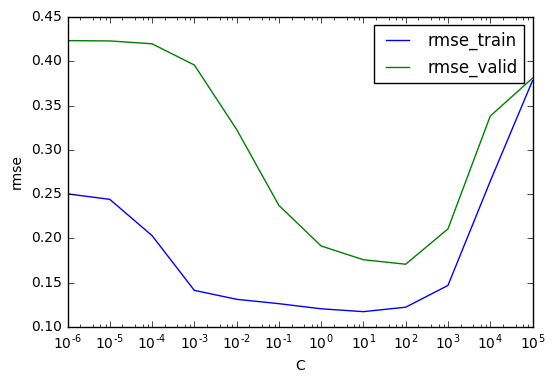

In [184]:
rmse = pd.DataFrame({'rmse_train':rmse_train, 'rmse_valid':rmse_valid}, index=alphas)
print 'best alpha'
print rmse.idxmin()
rmse.plot()
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('rmse')
plt.show()